# Age-Stratified Quarantine-Modified SEIR with Non-Linear Incidence Rates (Bongolan et al. 2021; Rayo et al. 2020; and Minoza et al. 2020)
## A COVID-19 Dynamics Model derived from the Kermack-McKendrick SIR Model

### Schematic Diagram

![alt text](transition.png "Schematic Diagram")

### System of Differential Equations

\begin{align}
    \frac{dS}{dt} & = \frac{- \beta Q(t) S I/N}{(1 + \alpha S/N)(1 + \epsilon I/N)} \\
    \frac{dE}{dt} & = \frac{\beta Q(t) S I/N}{(1 + \alpha S/N)(1 + \epsilon I/N)} - \sigma U E \\
    \frac{dI}{dt} & = \sigma U E - \gamma I \\
    \frac{dR}{dt} & = \gamma I
\end{align}

where 

<i>SEIR</i>
- $N$ = Total Population
- $S$ = Susceptible 
- $E$ = Exposed
- $I$ = Infectious 
- $R$ = Removed (dead and recovered) 

<i>Virus-host Parameters</i>
- $\beta$ = transmission rate
- $\sigma$ = incubation rate
- $\gamma$ = removal rate

<i>Additional Factors: Quarantine, Age, Non-Linear Incidence Rates</i>
- $Q(t)$ = time-varying quarantine variable (Bongolan et al. 2021)
- $U$ = age-stratified infection expectation (Rayo et al. 2020)
- $\alpha$ = behavioral factors, e.g., mask-wearing, physical distance (Minoza et al. 2020)
- $\epsilon$ = disease-resistance factors, e.g., healthy living, natural immunity (Minoza et al. 2020)

In [1]:
import numpy as np 

def get_asq_seir_nlir(n, beta, sigma, gamma, q, u, alpha, epsilon):
    def asq_seir_nlir(t, y):
        s = y[0]
        e = y[1]
        i = y[2]
        r = y[3]
        
        # ASQ-SEIR-NLIR
        ds_dt = (-beta*q*s*i/n) / ((1+alpha*s/n) * (1+epsilon*i/n))
        de_dt = ((beta*q*s*i/n) / ((1+alpha*s/n) * (1+epsilon*i/n))) - sigma*u*e
        di_dt = sigma*u*e - gamma*i
        dr_dt = gamma*i
        
        return np.array([ds_dt, de_dt, di_dt, dr_dt])
    
    return asq_seir_nlir

# 1. Initial Value Problem: Case of NCR

In [2]:
# COVID-19 cases as of Nov 20, 2021 from https://doh.gov.ph/covid19tracker 
# Vaccinated as of Nov 18, 2021 from https://www.rappler.com/newsbreak/data-documents/tracker-covid-19-vaccines-distribution-philippines
# Population of NCR as of May 1, 2020 from https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwii24Hdkqf0AhVQrlYBHc52CvsQFnoECAIQAQ&url=https%3A%2F%2Fpsa.gov.ph%2Fcontent%2Fhighlights-national-capital-region-ncr-population-2020-census-population-and-housing-2020&usg=AOvVaw2gAcuKEHpJVulQxmpP9pwe

vaccine_efficacy = 0.7 # expected value
fully_vaccinated = 8616362 # As of Nov 18, 2021

n = 13484462
e0 = 0 # Assumption
i0 = 4789 # Active CAse
r0 = 843882 + 10648 + vaccine_efficacy * fully_vaccinated # recovered + dead + immune
s0 = 13484462 - (e0 + i0 + r0)

## 2. Method: 4th-Order Runge-Kutta (RK4)

Pick a step-size $h>0$ and define 

$$y_{n+1} = y_n + \frac{1}{6} h (k_1 + 2k_2 + 2k_3 + k_4)$$
$$t_{n+1} = t_n + h$$

for $n = 0, 1, 2, 3, ...$, using 

$$k_1 = f(t_n, y_n)$$
$$k_2 = f(t_n + \frac{h}{2}, y_n + h \frac{k_1}{2})$$
$$k_3 = f(t_n + \frac{h}{2}, y_n + h \frac{k_2}{2})$$
$$k_4 = f(t_n + h, y_n + hk_3$$

In [3]:
def rk4(f, t0, y0, tn, h):
    """
    f  model
    t0 starting time
    y0 initial value
    tn time n
    h  step size
    """
    # Output variables 
    t = [t0]
    y = [y0]
    
    # current time (ti) and estimate (yi)
    ti = t0
    yi = y0
    
    while ti <= tn:
        # RK4 Definition
        k1 = f(ti, yi)
        k2 = f(ti+h/2, yi+h*k1/2)
        k3 = f(ti+h/2, yi+h*k2/2)
        k4 = f(ti+h, yi+h*k3)
        yi = yi + 1/6*h*(k1+2*k2+2*k3+k4)
        ti = ti + h
        
        # Appends time and estimate to result variables
        t.append(ti)
        y.append(yi)
        
    return t, y

## 3. Demo

### Example 1:

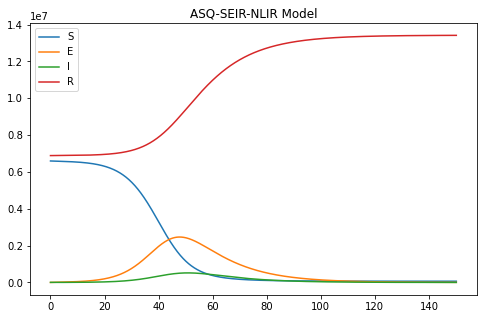

In [4]:
import pandas as pd

# Parameters (for DEMO purposes only; parameters taken from Minoza et. al.)
beta = 3.2
sigma = 1/7 # incubation period = 7 days
gamma = 0.33
q = 1
u = 0.5 # age 
alpha = 0.36 # behavioral factors
epsilon = 0.10 # disease-resistance factors: healthy living, natural immunity. 

# RK4 Call
f = get_asq_seir_nlir(n, beta, sigma, gamma, q, u, epsilon, alpha)
t0 = 0
y0 = np.array([s0, e0, i0, r0])
tn = 150
h = 0.1
t, y = rk4(f, t0, y0, tn, h)

# y = pd.DataFrame((t, y), columns=["S", "E", "I", "R"])
# print(y)

# Visualization
import matplotlib.pyplot as plt
plt.figure(1, [8, 5])
plt.title("ASQ-SEIR-NLIR Model")
plt.plot(t, y)
plt.legend(["S", "E", "I", "R"])
plt.show()

/Users/jimuelcelestejr/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


927817.0
10562.0
836229.0


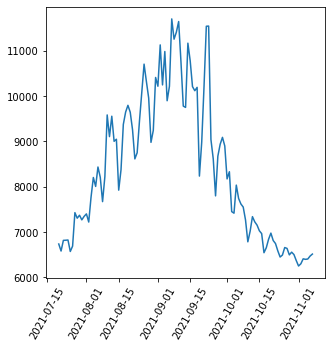

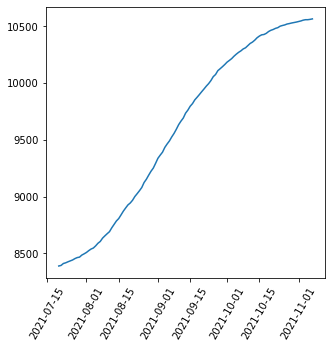

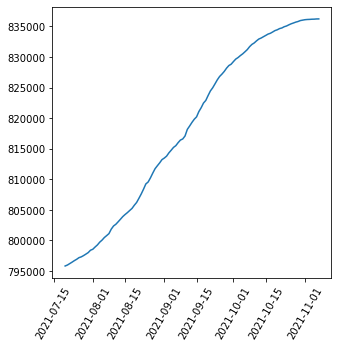

In [5]:
import copy 

class DOHCovid19DataExtractor:

    def __init__(self, filename):
        # Opens the COVID19 Data file as a Pandas DataFrame
        self.data = pd.read_csv(filename, index_col=0)
        self.filename = filename
        self.data['DateResultRelease'] = pd.to_datetime(self.data['DateResultRelease'])
        self.data['DateSpecimen'] = pd.to_datetime(self.data['DateResultRelease'])
        self.data['DateRecover'] = pd.to_datetime(self.data['DateRecover'])
        self.data['DateDied'] = pd.to_datetime(self.data['DateDied'])
        self.previous_data = []
        
    def generate_age_groups(self, size, groups):
        age_range = lambda x: (x * size, (x + 1) * size - 1)
        return [age_range(i) for i in range(groups)]
    
    def count_cases(self, column, data_filter, age_stratified=True):
        # Initializes the return variable: count
        # I = infectious, R = recovered, D = died
        count = {"I": [], "R": [], "D": []}

        # Filters the COVID19 data with the `column` column and data_filter
        data = self.data[self.data[column]==data_filter]
        # data = self.data 
        
        # Generates the age groups; size = 10
        age_groups = self.generate_age_groups(5, 16)
        age_groups.append((80,120)) # Special case: 80 and above

        for min_age, max_age in age_groups:
            # Filters the data with the Age column
            # Age of case must be within the min and max age
            age_group_data = data[data["Age"].between(min_age, max_age, inclusive=True)]

            # Counts the number of recovered, dead, and active
            recovered = len(age_group_data[age_group_data["HealthStatus"]=="RECOVERED"].index)
            dead = len(age_group_data[age_group_data["HealthStatus"]=="DIED"].index)
            active = len(age_group_data.index) - recovered - dead

            # Saves the counts to the return variable
            count["I"].append(active)
            count["R"].append(recovered)
            count["D"].append(dead)

        # Gets the sum of the age_stratified values when the age_stratified parameter is False
        if not age_stratified:
            for key in count: 
                count[key] = sum(count[key])

        return count
    
    def get_distribution(self, arr):
        arr_sum = sum(arr)
        return [i / arr_sum for i in arr]
    
    def get_case_distribution(self, column, data_filter):
        # Initializes the return variable: count
        # I = infectious, R = recovered, D = died
        cases_count = self.count_cases(column, data_filter)

        return {
            "I": self.get_distribution(cases_count["I"]), 
            "R": self.get_distribution(cases_count["R"]), 
            "D": self.get_distribution(cases_count["D"])
        }
    
    def cut_data(self, start, end, column):
        start_date = pd.Timestamp(start["y"], start["m"], start["d"])
        end_date = pd.Timestamp(end["y"], end["m"], end["d"])
        self.previous_data = copy.deepcopy(self.data)
        self.data = self.data[self.data[column] >= start_date]
        self.data = self.data[self.data[column] <= end_date]
    
    def undo_cutting(self):
        self.data = copy.deepcopy(self.previous_data)
    
    def get_cases(self, data_filters=[], date_filter="DateResultRelease", cumsum=False): 
        data = copy.deepcopy(self.data)
        
        if data_filters:
            for column, data_filter in data_filters:
                data = data[data[column]==data_filter]
                
        data = data.sort_values(by=[date_filter]) # Sorts data by datedied
        data = data[date_filter].value_counts() # Counts values and drops NaN entries
        data = data.sort_index() # Sorts index wrt date
        # data = data.asfreq('D').reset_index()[date_filter].fillna(0) 
        data = data.asfreq('D').fillna(0)
        data = data.cumsum() if cumsum else data 
        return data
    
    def get_deaths(self, data_filters, cumsum=False): 
        data_filters.append(("HealthStatus", "DIED"))
        return self.get_cases(data_filters, "DateDied", cumsum=cumsum)

    def get_recoveries(self, data_filters, cumsum=False): 
        data_filters.append(("HealthStatus", "RECOVERED"))
        return self.get_cases(data_filters, "DateRecover", cumsum=cumsum)
    
# Data frames
import matplotlib.pyplot as plt 
import numpy as np

batches = 3

ncr_cases = []
ncr_deaths = []
ncr_recoveries = []

cases_offset = 0
deaths_offset = 0
recoveries_offset = 0

for i in range(batches):
    # Opens the file and instantiates the extractor
    filename = "DOH COVID Data Drop_ 20211121 - 04 Case Information_batch_%i.csv" % (i)
    extractor = DOHCovid19DataExtractor(filename)

    # Sets start and end dates to filter records that are gathered within the dates (inclusive)
    start = {"m": 7, "d": 20, "y": 2021}
    end = {"m": 11, "d": 7, "y": 2021}
    
    # All Cases
    extractor.cut_data(start, end, 'DateResultRelease')
    ncr_cases.append(extractor.get_cases([("ProvRes", "NCR")], date_filter="DateSpecimen"))
    extractor.undo_cutting()
    
    # Deaths
    extractor.cut_data(start, end, 'DateDied')
    ncr_deaths.append(extractor.get_deaths([("ProvRes", "NCR")]))
    extractor.undo_cutting()
    
    # Recoveries
    extractor.cut_data(start, end, 'DateRecover')
    ncr_recoveries.append(extractor.get_recoveries([("ProvRes", "NCR")]))
    extractor.undo_cutting()
    
    # Offset 
    count = extractor.count_cases("ProvRes", "NCR", age_stratified=False)
    cases_offset += len(extractor.data[extractor.data["ProvRes"]=="NCR"].index)
    deaths_offset += count["D"]
    recoveries_offset += count["R"]

# Gets the sum of the cases in all the batches
cases = pd.concat(ncr_cases, axis=1).sum(axis=1) 
deaths = pd.concat(ncr_deaths, axis=1).sum(axis=1) 
recoveries = pd.concat(ncr_recoveries, axis=1).sum(axis=1)

# Cumulative Sum 
deaths = deaths.cumsum() + deaths_offset - deaths.sum()
recoveries = recoveries.cumsum() + recoveries_offset - recoveries.sum()

# Active Cases
active_cases = cases + cases_offset - deaths_offset - recoveries_offset

print(active_cases.sum())
print(deaths[-1])
print(recoveries[-1])

def plot_square(plot_id, data):
    plt.figure(plot_id, [5,5])
    plt.plot(data)
    plt.xticks(rotation=60)

plot_square(1, active_cases)
plot_square(2, deaths)
plot_square(3, recoveries)

### Example 2: Flattening the Curve (Quarantine, Behavioral Factors, Age)

# END OF DEMO

## References 

Bongolan, V.P., Minoza, J.M.A., de Castro, R., and Sevilleja, J.E., 2021, Age-Stratified Infection Probabilities Combined With a Quarantine-Modified Model for COVID-19 Needs Assessments: Model Development Study. J Med Internet Res 2021; 23(5): e19544. DOI: 10.2196/19544

Minoza, J. M., Sevilleja, J. E., de Castro, R., Caoili S.E., Bongolan, V. P., 2020, Protection after Quarantine: Insights from a Q-SEIR Model with Nonlinear Incidence Rates Applied to COVID-19. medRxiv (pre-print). doi.org/10.1101/2020.06.06.2012

Rayo, J.F., de Castro, R., Sevilleja, J.E., and Bongolan, V.P., 2020, Modeling the dynamics of COVID-19 using Q-SEIR model with age-stratified infection probability. medRxiv (preprint). DOI: 10.1101/2020.05.20.20095406

Uroz, G.E., 2010, The 4th-order Runge-Kutta method for a system of ODEs. https://en.smath.com/wiki/GetFile.aspx?File=Examples/RK4SystemEquations.pdf

[2. 1.]


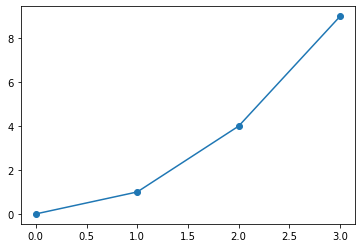

In [6]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd

x = pd.Series([0, 1, 2, 3])
y = pd.Series([0, 1, 4, 9])

def f(x, p, q):
    return x**p*q

popt, pcov = curve_fit(f, x, y)
p, q = popt
print(popt)

plt.scatter(x, y)
plt.plot(x, f(x, p, q))